In [2]:
%logstop
%logstart -rtq ~/.logs/ML_Dimension_Reduction.py append
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Dimension Reduction

Dimension reduction is an unsupervised learning technique; no labels are used for the process. The goal of dimension reduction is to take observations characterized by a set of features and reduce the number of features. Hence, we are _reducing_ the dimension of our data points. For example, instead of using 100 features to characterize each observation, dimension reduction techniques allow us to represent the data using a truncated set, e.g., using 10 features instead of the original 100. While reducing the dimension will result in some information loss, the algorithms we will discuss aim to keep this loss at a minimum.

Several applications of dimension reduction are:

1. Reducing file sizes
1. Visualizing high dimensional data sets
1. Faster training and predicting times for supervised machine learning models
1. Generating a better, truncated, set of new features to represent our data

The notebook will discuss three commonly used dimension reduction techniques and how they are implemented in `scikit-learn`.

## Mathematics of dimension reduction

Dimension reduction techniques work by first creating a new set of dimensions/axes and _projecting_ the data to the new space. The process of projecting is a matrix multiplication,

$$ X' = XP,$$

where $X$ is the matrix of our original data, $n$ observations and $p$ columns/features, $X'$ is the matrix of our data in the new space, and $P$ is the matrix that projects our data onto the new feature space. $P$ has $p$ rows and $p$ columns where each column is a vector that represents a new dimension. The vectors are ordered from most important to least important with regards to capturing the variation in the data. If we only include the first $m$ columns of $P$, then the matrix multiplication will project our data onto a lower dimensional space. The matrix multiplication of an $n$ by $p$ matrix with a $p$ and $m$ matrix will result in a $n$ by $m$ matrix; our transformed data set has less features,

$$ X' = X \tilde{P}, $$

where $\tilde{P}$ is the truncated form of $P$ that has $m$ columns where $m < p$. The dimension reduction algorithms work by finding $P$ given an objective function. The objective function is typically constructing the projection matrix $P$ such that using the truncated form $\tilde{P}$ can still retain the majority of the information in our data set.

## Principal component analysis

Principal component analysis (PCA) is a dimension reduction technique that takes a data set characterized by a set of possibly correlated features and generates a new set of features that are uncorrelated. It is used as a dimension reduction technique because the new set of uncorrelated features are chosen to be efficient in terms of capturing the variance in the data set.

Let's examine a case where we have a data set of only two dimensions. In practice, PCA is rarely used when the dimension of the data set is already low. However, it is easier to illustrate the method when we have two or three dimensions.

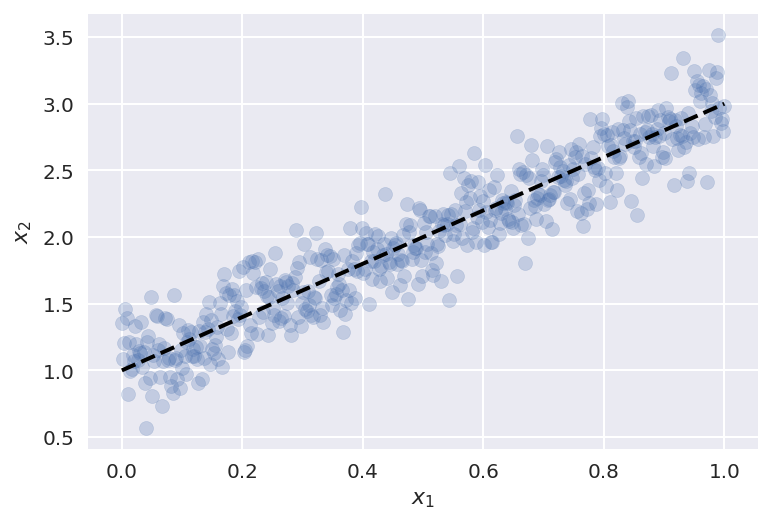

In [4]:
np.random.seed(0)
x1 = np.linspace(0, 1, 500)
x2 = 2*x1 + 1 + 0.2*np.random.randn(500)
X = np.vstack((x1, x2)).T

plt.scatter(*X.T, alpha=0.25)
plt.plot(x1, 2*x1 + 1, '--k', linewidth=2)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$');

The data plotted is characterized by two dimensions, however, most of the variation does not occur in either of the two dimensions. Most of the points "follow" along the direction plotted in the dashed line. The variables $x_1$ and $x_2$ are highly correlated; as $x_1$ increases, in general, so does $x_2$ and vice versa.

Instead of using the original two features, $x_1$ and $x_2$, perhaps we can use a different set of features, $\xi_1$ and $\xi_2$. The first chosen feature $\xi_1$ should be aligned in the direction of greatest variation while the second will be _orthogonal_ to the first. The new axes/dimensions are referred to as _principal components_. Let's visualize the data set but using the principal components $\xi_1$ and $\xi_2$ rather than the original features.

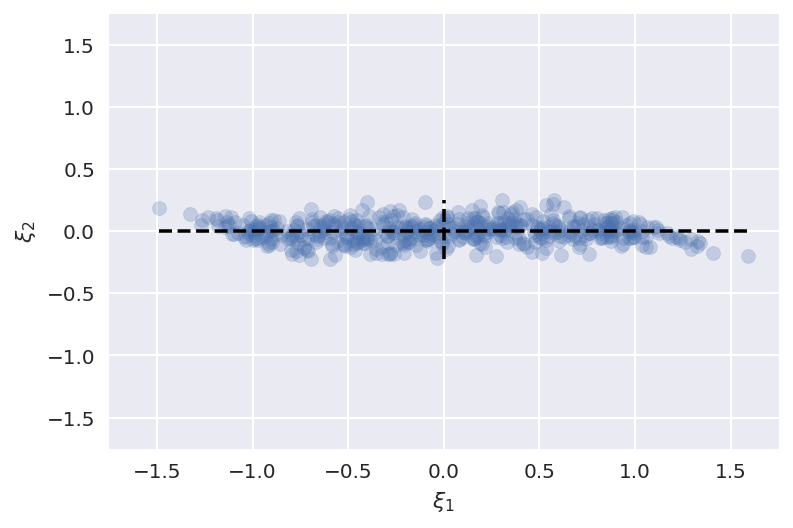

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
Xt = pca.fit_transform(X)

xi_1_max, xi_2_max = Xt.max(axis=0)
xi_1_min, xi_2_min = Xt.min(axis=0)

plt.hlines(0, xi_1_min, xi_1_max, linestyles='--')
plt.vlines(0, xi_2_min, xi_2_max, linestyles='--')

plt.scatter(*Xt.T, alpha=0.25)
plt.xlim([-1.75, 1.75])
plt.ylim([-1.75, 1.75])
plt.xlabel('$\\xi _1$')
plt.ylabel('$\\xi _2$');

In the figure, we can clearly observe that $\xi_1$ is the dimension with the largest variation. In the PCA algorithm, $\xi_1$ is chosen to capture as much of the variation as possible, with $\xi_2$ picking up the rest of remaining variation. Now, if we want to use one dimension to describe our data, we would keep $\xi_1$ and drop $\xi_2$, ensuring we keep as much of the information in our data set using just one dimension. Further, notice how the new dimensions are not correlated. As we move from lower to higher values of $\xi_1$, $\xi_2$ does not predictability increase or decrease.

In the visualization below, you can represent the data points in the space of either one (reduced) or two principal components or project back onto the original space _after_ reducing the dimension.

In [6]:
from ipywidgets import interact, fixed

np.random.seed(0)
ind = np.random.choice(Xt.shape[0], 50)

def reduce_dim(X, Xt, step='one PC'):
    if step == 'original space':   
        pca = PCA(n_components=1)
        X_t = pca.fit_transform(X)
        plt.scatter(*pca.inverse_transform(X_t[ind, :]).T)
        plt.scatter(*X[ind, :].T, c='b', alpha=0.1)

        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$');
        
        return 
    
    elif step == 'two PC':
        plt.scatter(*Xt[ind, :].T)

        for x in Xt[ind, :]:
            plt.vlines(x[0], 0, x[1], linestyles='--')    
    else:
        plt.scatter(Xt[ind, 0], np.zeros(50))
        plt.scatter(*Xt[ind, :].T, alpha=0.1, c='b')

    plt.xlim([-1.75, 1.75])
    plt.ylim([-0.5, 0.5])
    plt.xlabel('$\\xi _1$')
    plt.ylabel('$\\xi _2$')
        
interact(reduce_dim, X=fixed(X), Xt=fixed(Xt), step=['two PC', 'one PC', 'original space']);

interactive(children=(Dropdown(description='step', index=1, options=('two PC', 'one PC', 'original space'), va…

Black dashed lines = info lost when collapsing from 2D to 1D.

## PCA in `scikit-learn`

In `scikit-learn`, dimension reduction algorithms are transformers. The choice of having these algorithms as transformers makes sense since they apply a transformation on the data set. Let's illustrate the syntax for the PCA algorithm in `scikit-learn`. Note, other dimension reduction techniques in `scikit-learn` will have the same interface. For most of these algorithms, the data needs to be centered and scaled to work properly. `PCA` automatically centers the data but **does not** scale it. `StandardScaler` is often used for preprocessing the data prior to applying PCA.

In [7]:
from sklearn.datasets import fetch_california_housing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data = fetch_california_housing()
X = data['data']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=4)
Xt = pca.fit_transform(X_scaled)

print("number of dimension before reduction: {}".format(X_scaled.shape[-1]))
print("number of dimension after reduction: {}".format(Xt.shape[-1]))

number of dimension before reduction: 8
number of dimension after reduction: 4


When the `fit` method is called, the transformer learns the matrix $\tilde{P}$ to use for truncating our data set given the number of features/components, `n_components`, we want to have for our transformed data set. The matrix $\tilde{P}^T$, where $T$ signifies the transpose, is stored in the attribute `components_` of the PCA transformer object.

In the example above, we have gone from 8 to 4 dimensions. However, we don't know how much of the original information we have retained. With a trained PCA object, the explained variance of each new components is stored in the `explained_variance_` and `explained_variance_ratio_` attribute, the latter being normalized by the total variance.

In [8]:
print("explained variance ratio: {}".format(pca.explained_variance_ratio_))
print("cumulative explained variance ratio: {}".format(np.cumsum(pca.explained_variance_ratio_)[-1]))

explained variance ratio: [0.25336868 0.23516245 0.15888635 0.12887971]
cumulative explained variance ratio: 0.7762971822222974


Thus, with just 4 components/features, we are able to capture about 77% of the variance of the original full order data set. We could also calculate the total explained variance by using the `inverse_transform` method. After transforming our data to obtain the reduced form, we can apply the inversion to obtain the approximation of our data in the original feature space. Then, we can calculate the resulting variance.

In [9]:
print("retained variance: {}".format(pca.inverse_transform(Xt).var()))

retained variance: 0.7762971822222977


## Implementation details of PCA

We have not discussed exactly how PCA obtains the new features. The matrix $\tilde{P}$ is chosen such that 

$$ \| X_c - X'\tilde{P}^T \|_2 $$

is minimized. The subscript $c$ refers to the centered data set. The product $X'\tilde{P}^T$ is the reconstruction of our data onto the original feature space. There are several algorithms to solve for the principal components but a popular one involves applying singular value decomposition. Singular value decomposition (SVD) is an algorithm to decompose a matrix into a product of three matrices,

$$ X_c = U \Sigma P^T. $$

You can envision that the matrix $X_c$ represents a transformation that can be broken into three steps: an initial rotation $P^T$, a scaling $\Sigma$, and a final rotation $U$. By applying SVD on $X_c$, the matrix $P$ is solved. The matrix $\Sigma$ is a diagonal matrix, a matrix with non-zero values along the diagonal, 

$$ \Sigma = \left[ \begin{array}{ccc} 
\sigma_1 & \\
& \sigma_2 & \\
&& \ddots & \\
&&&
\end{array} \right]$$

The diagonal values are ordered such that $|\sigma_1| \ge |\sigma_2| \ge \cdots |\sigma_{p-1}| \ge |\sigma_p|$. The larger the absolute value of $\sigma$, the greater amount of variation exists in that direction/component. Thus, to generate $\tilde{P}$ to truncate the data set, the first $m$ components/columns of $P$ are kept.

## Choosing the number of components

How does one chose the best number of components to use? The answer is not clear cut; using more components will increase the explained variance but using too many will defeat the purpose of reducing the number of dimensions. The best way to determine a good number of components to use is to construct a plot of the cumulative explained variance versus the number of components. We need to identify at what point is increasing the number of components no longer has an appreciable gain in explained variance, the point of diminishing returns. Identifying this region is accomplished using an "elbow plot", named because of the resemblance of an arm with a bent elbow. Let's create the elbow plot for the California data and see how many components we need to keep to explain at least 90% of the variance.

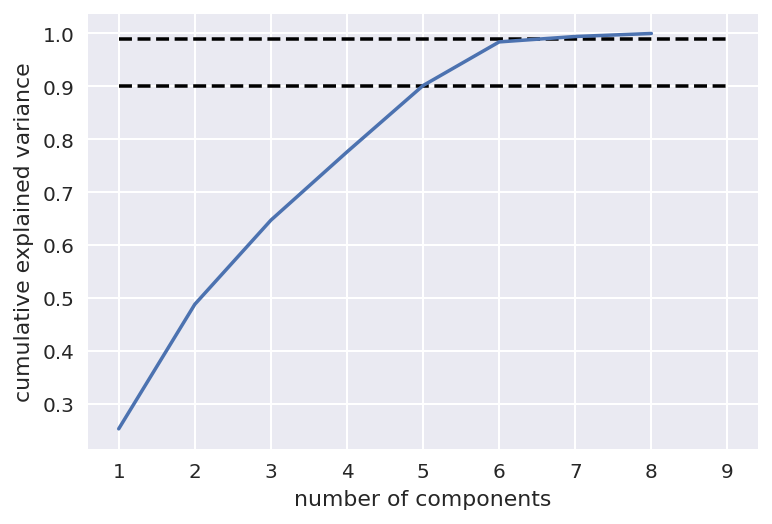

In [10]:
X_scaled = scaler.fit_transform(X)
p = X_scaled.shape[-1]
pca = PCA(n_components=p)
pca.fit(X_scaled)
cumulative_explained_var = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, p + 1), cumulative_explained_var)
plt.hlines(0.9, 1, p+1, linestyles='--')
plt.hlines(0.99, 1, p+1, linestyles='--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

It appears we only need to use 5 and 6 components if we want to retain 90% and 99% of the variance, respectively. Note, we usually see more dramatic performance when we have more features. With more features, we are more likely to have a lot of redundant information and correlated features.

## Truncated Singular Value Decomposition

To apply PCA, the data set needs to be centered, i.e., the features needs to have zero mean. Centering the data becomes a problem when we are representing our data using a sparse matrix. To center the data, you need to subtract each entry in the matrix by a value; all zero entries are now non-zero. If we have a sparse matrix, an alternative is to use the `TruncatedSVD` class. The `TruncatedSVD` transformer objects work the same as PCA but it does not center the data prior to finding the principal components.

## Non-negative matrix factorization

In certain applications, our data only has non-negative values. For example, in natural language processing, the bag-of-words model yields a matrix of only non-negative values. In these applications, it is important that any dimension reduction scheme preserves the non-negative nature of any resulting matrices, keeping explicability in our analysis. A variation of PCA but with the added constraint that the derived matrices are non-negative is called non-negative matrix factorization (NMF).

NMF is often used in the field of **topic modelling**; what are the major topics/ideas in a corpus. We will apply NMF to the newsgroup data set, http://qwone.com/~jason/20Newsgroups/. The first step is to transform our text data into a structured form. We will use `TfidfVectorizer` transformer that creates a data set where our features our words and the entries is a weighted frequency of a particular word. We will formally discuss the field of natural language processing in a separate notebook. When applying NMF, the resulting new dimensions represent a collection of words, our old features, which we can refer to as a topic. For each derived new component, we can display the top words that most contribute to that new dimension. With those top words identified, we can look to see what topic or concept each new feature represents.

### Topic Modelling Example!!

In [11]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

data = fetch_20newsgroups(shuffle=True, remove=('headers', 'footers', 'quotes'))
X = data['data']

n_topics = 10
n_top_words = 20

tfidf = TfidfVectorizer(stop_words='english')
nmf = NMF(n_components=n_topics, random_state=0)
pipe = Pipeline([('vectorizer', tfidf), ('dim-red', nmf)])
pipe.fit(X)

feature_names = tfidf.get_feature_names()

for i, topic in enumerate(nmf.components_):
    print("Topic: {}".format(i))
    indices = topic.argsort()[-n_top_words-1:-1]
    top_words = [feature_names[ind] for ind in indices]
    print(" ".join(top_words), "\n")

Topic: 0
did thing way make ll things right going say want really car people time ve good know think like just 

Topic: 1
software motif os pc ftp screen run application ms server problem version running using use program files window dos file 

Topic: 2
lord man christianity belief sin hell heaven truth life church people say does christians christian christ faith believe bible jesus 

Topic: 3
migraine probably patients weight medical blood lyme edu soon banks gordon surrender skepticism intellect shameful cadre pitt chastity n3jxp dsl 

Topic: 4
enforcement privacy data des phone bit encrypted nsa law security secure public use algorithm escrow government keys clipper encryption chip 

Topic: 5
quantum bios seagate power internal bus rom tape cable mac boot cd hd floppy controller hard ide drives disk scsi 

Topic: 6
chicago pitching runs best toronto 10 detroit baseball player nhl teams league win hockey play season players year games team 

Topic: 7
appreciate ftp interested edu p

These are the words that 'contribute' most to the new features / PC's / topics!

From the analysis, we can see that topic 1 represents "computers" while topic 2 represents "Christianity".

##  Using PCA with a supervised model

A common usage of PCA is to truncate the number of dimensions so that the training and predicting times of a supervised machine learning models will be significantly faster. For example, for decision trees, the training and time complexity with respect to the number of features is $O(p)$. Thus, reducing our features by half will reduce our training by half as well. Let's see the effect of using PCA with conjunction with decision trees for `make_classification` data.

In [12]:
from shutil import rmtree
from tempfile import mkdtemp
import time

from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier

X, y = make_classification(n_samples=10000, n_features=100, n_informative=10, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
pca = PCA(n_components=10)
tree = DecisionTreeClassifier()

cache = mkdtemp()
pipe = Pipeline([('scaler', scaler), ('dim-red', pca), ('clf', tree)], memory=cache)
param_grid = {'clf__max_depth': range(2, 20)}
grid_search = GridSearchCV(pipe, param_grid, cv=3, n_jobs=2)

t_0 = time.time()
grid_search.fit(X_train, y_train)
t_elapsed = time.time() - t_0

print("training time: {:g} seconds".format(t_elapsed))
print("test accuracy: {}".format(grid_search.score(X_test, y_test)))
rmtree(cache)

training time: 7.6831 seconds
test accuracy: 0.777


In [13]:
pipe = Pipeline([('scaler', scaler), ('clf', tree)], memory=cache)
param_grid = {'clf__max_depth': range(2, 20)}
grid_search = GridSearchCV(pipe, param_grid, cv=3, n_jobs=2)

t_0 = time.time()
grid_search.fit(X_train, y_train)
t_elapsed = time.time() - t_0

print("training time {:g} seconds".format(t_elapsed))
print("test accuracy {}".format(grid_search.score(X_test, y_test)))
rmtree(cache)

training time 30.8447 seconds
test accuracy 0.862


By transforming the data set to have 10 rather than 100 dimensions, the training time is reduced by a third. However, the cost of faster training is accuracy.

## Dimension reduction for visualization

Another use for dimension reduction is for visualization of high dimension data set. It is difficult to visualize more than two or three dimension. One approach is to choose two or three variable when plotting. However, this approach will only visualize the relationship of the data for the given chosen variables. While we cannot visual the entire relationship for all the variables in our data set, we can generate two or three new features that will capture as much of the variation as possible, more than just using two of three variables in the original set. Let's visualize the iris data set which has four components by using two generated features.

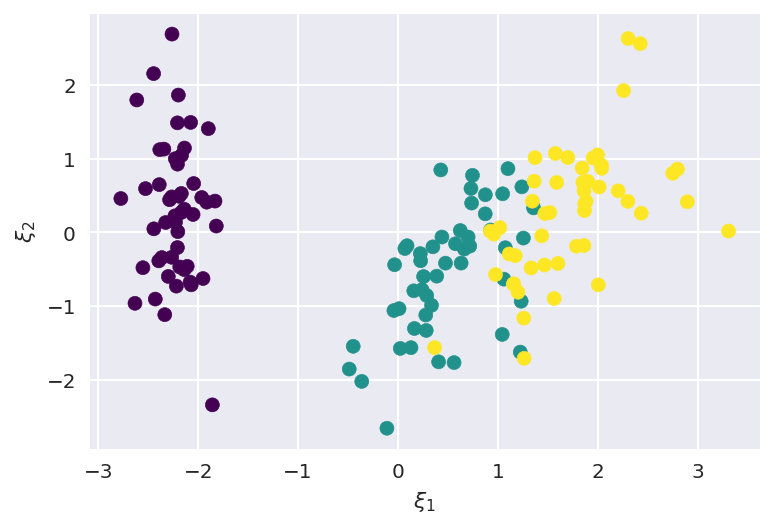

In [14]:
from sklearn.datasets import load_iris

data = load_iris()
X = data['data']
y = data['target']

pca = PCA(n_components=2)
pipe = Pipeline([('scaler', StandardScaler()), ('dim-red', pca)])
Xt = pipe.fit_transform(X)

plt.scatter(*Xt.T, c=y, cmap='viridis')
plt.xlabel('$\\xi_1$')
plt.ylabel('$\\xi_2$');

In [15]:
explained_var = np.cumsum(pca.explained_variance_ratio_)
print('explained variance with two dimensions: {}'.format(explained_var[-1]))

explained variance with two dimensions: 0.9581320720000165


In [16]:
explained_var # (PC1, PC1+2)

array([0.72962445, 0.95813207])

## Exercises

For the following exercises, use the Olivetti face data set, a set of 400 images of faces from 10 individuals. Each image has 4096 pixels, representing our features. The data set can be retrieved by using the `fetch_olivetti_faces` function in the `sklearn.datasets` module.

1. Apply NMF to generate new features and visualize them. Using `matplotlib`, images can be visualized using the `plt.imshow` function.
2. Train a supervised machine learning model to classify the images. Repeat but use a dimension reduction technique. Compare both the test score and the time required to train the model.
3. In the demonstration of using PCA in conjunction of supervised machine learning, we did not _simultaneously_ tune the decision tree regressor or the number of components. Tune both of these estimators.

**1. Apply NMF to generate new features and visualize them. Using `matplotlib`, images can be visualized using the `plt.imshow` function.**

In [18]:
from sklearn.datasets import fetch_olivetti_faces

data = fetch_olivetti_faces()
X = data['data']
y = data['target']

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/jovyan/scikit_learn_data


In [23]:
X.shape # (n, p=pixels)

(400, 4096)

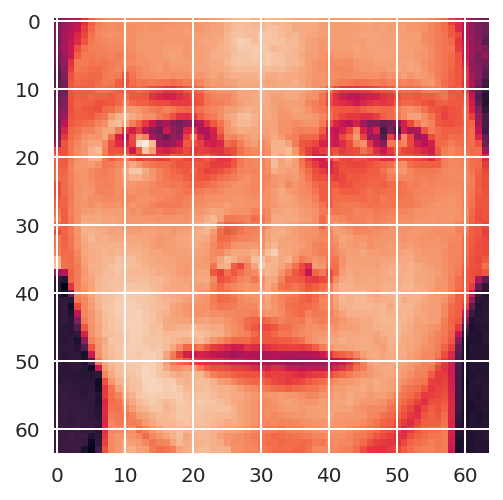

In [26]:
plt.imshow(X[0, :].reshape(64, 64))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [28]:
nmf = NMF(n_components=20)
nmf.fit(X_train)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=20, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

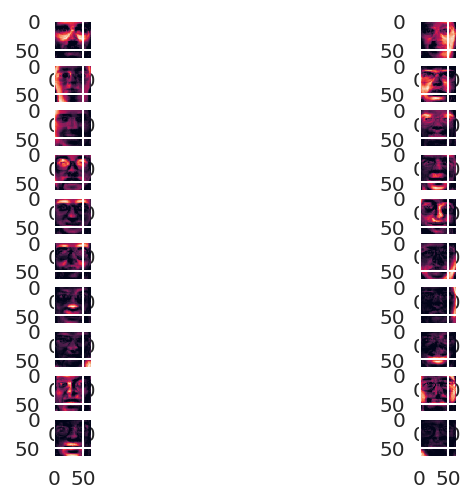

In [29]:
for i, component in enumerate(nmf.components_):
    face = component.reshape(64, 64)
    plt.subplot(10, 2, i+1)
    plt.imshow(face)

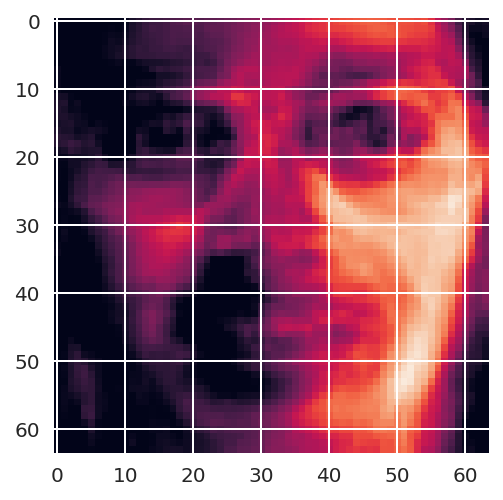

In [31]:
plt.imshow(nmf.components_[1, :].reshape(64, 64)) # 1st component

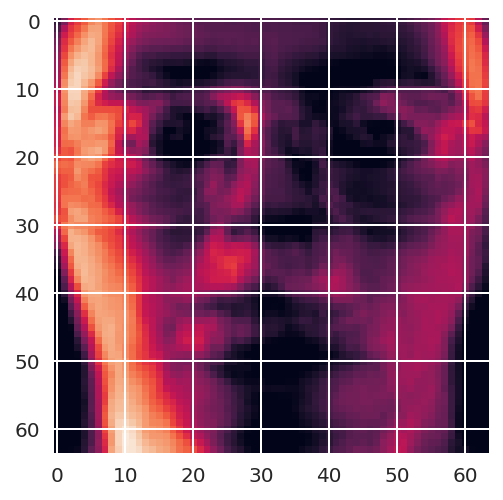

In [36]:
plt.imshow(nmf.components_[2, :].reshape(64, 64)) # 2nd component

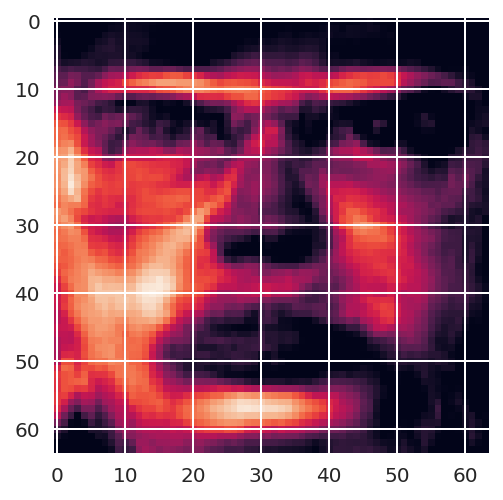

In [35]:
plt.imshow(nmf.components_[3, :].reshape(64, 64)) # 3rd component

Human faces will be a weighted combination of these component images!

In [37]:
# Remap to higher dim + check lost info
X_reduced = nmf.transform(X_train)

In [42]:
X_reconstructed = nmf.inverse_transform(X_reduced)

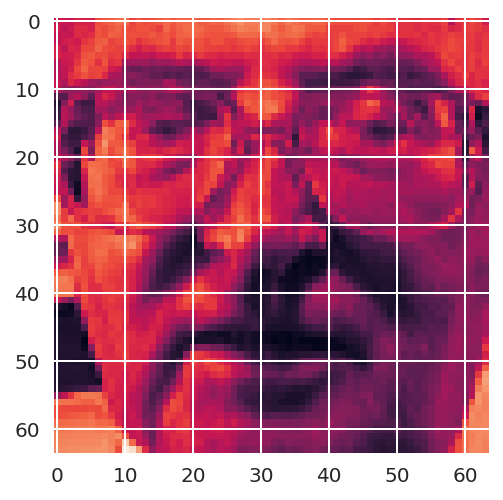

In [41]:
# original 1st image
plt.imshow(X_train[0, :].reshape(64, 64))

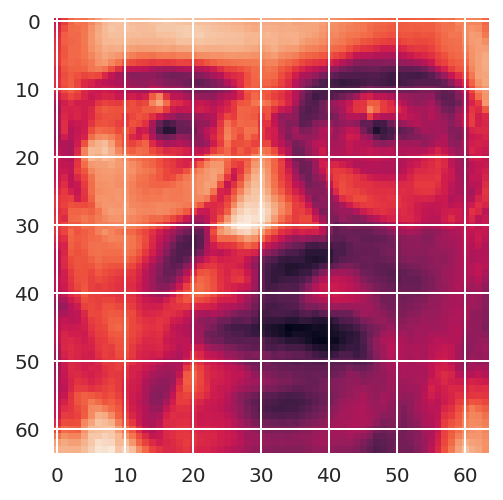

In [43]:
# reconstructed first image - slight loss of detail!
plt.imshow(X_reconstructed[0, :].reshape(64, 64))

If want better reconstructed, set `n_components` in `NMF()` to greater value - capture more explanatory variance.

**2. Train a supervised machine learning model to classify the images. Repeat but use a dimension reduction technique. Compare both the test score and the time required to train the model.**

In [54]:
# compare model performance
import time

def fit_model(func):
    def wrapper(*args, **kwargs):
        model = func(*args, **kwargs)
        t_0 = time.time()
        model.fit(X_train, y_train)
        t_elapsed = time.time() - t_0
        
        print('runtime: {:g}'.format(t_elapsed))
        print('training_accuracy: {:g}'.format(model.score(X_train, y_train)))
        print('testing_accuracy: {:g}'.format(model.score(X_test, y_test)))
        
        return model
    
    return wrapper

In [55]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.svm import SVC

# create model construction function for ease
@fit_model
def construct_nmf_model():
    nmf = NMF(n_components=100) # usually use emblow plot to decide
    clf = SVC(kernel='rbf')
    cv = StratifiedKFold(3)
    param_grid = {'C': np.logspace(-3, 2, 100),
                  'gamma': np.logspace(-3, 2, 100)}
    random_search = RandomizedSearchCV(clf, param_grid, cv=cv, n_iter=50, n_jobs=2, random_state=0, verbose=1)
    pipe = Pipeline([
        ('dim-red', nmf), ('classifier', random_search)
    ])
    
    return pipe
    

In [56]:
# compare to no DR procedure
@fit_model
def construct_no_nmf_model():
    clf = SVC(kernel='rbf')
    cv = StratifiedKFold(3)
    param_grid = {'C': np.logspace(-3, 2, 100),
                  'gamma': np.logspace(-3, 2, 100)}
    random_search = RandomizedSearchCV(clf, param_grid, cv=cv, n_iter=50, n_jobs=2, random_state=0, verbose=1)
    
    return random_search

In [57]:
nmf_model = construct_nmf_model() # 22 secs, lower test accuracy

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 116 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    5.8s finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


runtime: 21.9987
training_accuracy: 1
testing_accuracy: 0.825


In [58]:
no_nmf_model = construct_no_nmf_model()  # 104 secs

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   31.7s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:  1.7min finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


runtime: 104.109
training_accuracy: 1
testing_accuracy: 0.9875


**3. In the demonstration of using PCA in conjunction of supervised machine learning, we did not _simultaneously_ tune the decision tree regressor or the number of components. Tune both of these estimators.**

Use elbow plot to 'tune' PC number. **Note:** DR doesn't always sacrifice performance - can reduce overfitting!

## PCA Variants

Full PCA: $O(n^2*p) + O(n^3)$.

Randomized PCA (change `svd_solver` to randomized): $O(m^2*p) + O(m^3)$, where $m$= #PCs.

Incremental PCA (online learning).

Kernel PCA (non-linear projections - creates linearly-separable projection):
https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html. 


In [60]:
from sklearn.decomposition import IncrementalPCA, KernelPCA

n_batches=50

ipca = IncrementalPCA(n_components=50)

for X_batch in np.array_split(X_train, n_batches):
    ipca.partial_fit(X_batch)

ValueError: n_components=50 must be less or equal to the batch number of samples 7.